# Active Learning with Multiple Types of Annotators

In [1]:
# import required packages
import sys
sys.path.append("../..")
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from annotlib import ClusterBasedAnnot
from annotlib import ClassifierBasedAnnot
from annotlib import DynamicAnnot
from annotlib import StandardAnnot
from annotlib import MultiAnnotTypes

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle

from scipy.stats import mode

In a real-world scenario, it may be the case that many annotators are available for providing class labels. 
Since these annotators are often human, their skill, experience, and type of decision making may completely differ from each other. 

With reference to the simulation of such a setting, this diversity of annotators is achieved by allowing multiple annotator types.

## Experimental Setup
The class [MultiAnnotTypes](../annotlib.multi_types.rst) is able to handle different types of annotators. 

For illustration, let's set up a simple active learning scenario, where the aim is to reduce the labelling cost for building a high performance classifier. 

In this scenario, we use a two-dimensional (`n_features=2`) artificial data set consisting of `n_samples=200` samples of `n_classes=3` different classes. 

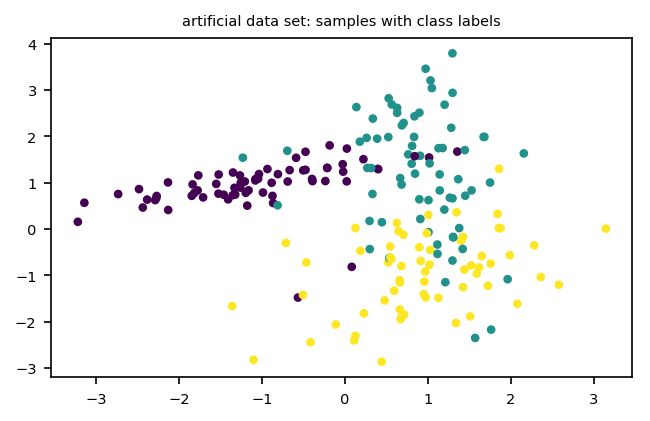

In [2]:
X, y_true =  make_classification(n_samples=200, n_features=2, n_informative=2, 
                                 n_redundant=0, n_repeated=0, 
                                 n_classes=3, n_clusters_per_class=1, 
                                 flip_y=.05, random_state=0)
X, y_true = shuffle(X, y_true, random_state=2)
plt.figure(figsize=(5, 3), dpi=150)
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y_true, s=10)
plt.title('artificial data set: samples with class labels', fontsize=7)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.show()

To simplify the settings, we rely on **random sampling** as query strategy. 

In other words, in each cycle a sample is randomly selected from the unlabeled set `X_unlabelled` to be labelled by each annotator. 
For classification, we use the **$k$-nearest-neighbour** classifier, which is retrained after each active learning cycle on the updated labelled set `X_labelled`. 
In this example, there are `n_annotators=4` different annotators available $\{a_0, a_1, a_2, a_3\}$:

- $a_0$: annotator simulated by means of clustering,
- $a_1$: annotator simulated by a classifier (support vector machine (SVM)),
- $a_2$: omniscient annotator,
- $a_3$: initially omniscient annotator, whose labelling performance decreases during the active learning.

To show the influence of the annotator selection, we compare the learning curves of the classifier's accuracy when trained with the class labels of each individual annotator. 
Moreover, we compare these learning curves to the learning curve of the classifier trained on the labels inferred from majority votes of the annotators.
The learning curves are measured by means of **20 random splits** into **60%** unlabelled data `X_unlabelled` and **40%** test data `X_test`.

The annotators are recreated on each unlabeled set.

In each iteration, an unlabelled sample is selected from the unlabeled set `X_unlabelled` and presented to all annotators who provide their class labels for the selected sample. 
The provided class labels of the sample form the labelled set `X_labelled`.

☝🏽This labelled set is divided into five different training sets, so that there is a training set generated by each annotator and a training set with the majority vote labels. These training sets are used to train the classifiers to be compared.

In [3]:
# number of repeats
n_repeats = 20

# maximal number of labelled samples
max_n_labelled = 100

# number of initially labelled samples
n_init = 5

# accuracies
accuracies = np.zeros((5, max_n_labelled+1-n_init))

# set up classifer
knn = KNeighborsClassifier(n_neighbors=5)

for r in range(n_repeats):
    # dividie and preprocess data
    X_unlabelled, X_test, y_unlabelled, y_test = train_test_split(X, y_true, 
                                                                test_size=.4, 
                                                                random_state=r)
    stand_scaler = StandardScaler().fit(X_unlabelled)
    X_unlabelled = stand_scaler.transform(X_unlabelled)
    X_test = stand_scaler.transform(X_test)
    
    # simulate annotator types
    clust_annot = ClusterBasedAnnot(X=X_unlabelled, y_true=y_unlabelled, 
                                    n_annotators=1, random_state=r,
                                    cluster_labelling_acc='equidistant')
    classif_annot = ClassifierBasedAnnot(X=X_unlabelled, y_true=y_unlabelled, 
                                         n_annotators=1, 
                                         train_ratios=[[.05, 0.05, 0.05]], 
                                         random_state=r)
    omnis_annot = StandardAnnot(X=X_unlabelled, Y=y_unlabelled.reshape(-1,1))
    dyn_annot = StandardAnnot(X=X_unlabelled, Y=y_unlabelled.reshape(-1,1))
    dyn_annot = DynamicAnnot(dyn_annot, y_unique = np.unique(y_true), 
                             learning_rates=[-0.05], random_state=r)    
    
    # create instance of multiple types of annotators
    annotator_types = [clust_annot, classif_annot, omnis_annot, dyn_annot]
    annotators = MultiAnnotTypes(annotator_types=annotator_types)

    # create inital labelled set
    X_labelled = X_unlabelled[:n_init-1]
    Y_labelled = annotators.class_labels(X_labelled, query_value=n_init-1, 
                                         y_true=y_unlabelled[:n_init-1])
    
    # execute active learning cycle
    for query_idx in range(n_init, max_n_labelled):
        Y_queried = annotators.class_labels([X_unlabelled[query_idx, :]], 
                                            query_value=1, 
                                            y_true=[y_unlabelled[query_idx]])
        X_labelled = np.append(X_labelled, [X_unlabelled[query_idx, :]], axis=0)
        Y_labelled = np.append(Y_labelled, Y_queried, axis=0)
        for a_idx in range(annotators.n_annotators()):
            knn.fit(X_labelled, Y_labelled[:, a_idx])
            score = knn.score(X_test, y_test)
            accuracies[a_idx, query_idx-n_init+1] += score
        y_mode = mode(Y_labelled, axis=1)[0].ravel()
        knn.fit(X_labelled, y_mode)
        score = knn.score(X_test, y_test)
        accuracies[-1, query_idx-n_init+1] += score

accuracies /= n_repeats

## Results
The learning curves in the plot below show the development of the accuracy over the increasing number of labelled samples.

As expected, the classifier trained with the labels of the omniscient annotator outperforms the classifiers trained with the labels of the other annotators. 
The accuracy of the classifier trained with the samples labelled by the omniscient annotator converges faster to a higher accuracy compared to the other classifiers, since no falsely labelled samples are in the training set.

Another interesting observation is the development of the learning curve of the classifier trained with the labels of the dynamic annotator. 
At the beginning, the accuracy increases until the training set contains about 20 training samples.
Subsequently, the accuracy is decreasing. 
This decreasing learning curve occurs because of the negative learning rate of the dynamic annotator, which impose a decreasing labelling performance. 
Hence, during the active learning the ratio of wrongly labelled samples increases, so that the performance of the classifier is getting worse.

The accuracy of the classifier trained with the samples labelled by means of majority vote is about the same lavel as the classifier trained only with the labels of the annotator simulated by a SVM. 
The majority vote method has the disadvantage of giving the same weight to each annotator, so that the bad annotators have the same weight as the omniscient annotator.

☝🏽This example illustrates how our annotator simulation library **annotlib** can be used to evaluate active learning strategies in combination with simulated annotators. 
Moreover, it indicates the importance of annotator selection and the combination of their responses.

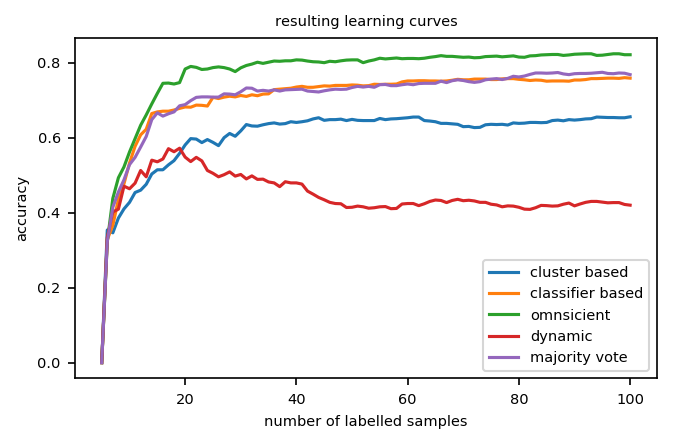

In [4]:
labels = ['cluster based', 'classifier based', 'omnsicient', 
          'dynamic', 'majority vote']
plt.figure(figsize=(5, 3), dpi=150)
for y_arr, label in zip(accuracies, labels):
    plt.plot(range(n_init, max_n_labelled+1), y_arr, label=label)
plt.legend(fontsize=7)
plt.title('resulting learning curves', fontsize=7)
plt.xlabel('number of labelled samples', fontsize=7)
plt.ylabel('accuracy', fontsize=7)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.show()